<a href="https://colab.research.google.com/github/Stavroskiig/SVM-CIFAR-10/blob/main/NN_2nd_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Νευρωνικά Δίκτυα - Βαθιά Μάθηση**

2η Υποχρεωτική Εργασία


---
* **Στόχος**:
Ζητούμενο της εργασίας είναι να γραφεί πρόγραμμα σε οποιαδήποτε γλώσσα προγραμματισμού το οποίο να υλοποιεί ένα **Support Vector Machine**. Το SVM αυτό θα εκπαιδευτεί για να επιλύει το πρόβλημα του διαχωρισμού 2 κλάσεων που υπάρχουν στο **CIFAR-10**.

* **Γλώσσα**:
Επιλέγω να εργαστώ σε Python χρησιμοποιώντας την βιβλιοθήκη `PyTorch` για την ανάπτυξη των νευρωνικών μοντέλων, η οποία είναι αρκετά δημοφιλής στην ερευνητική και εκπαιδευτική κοινότητα.

* **Βάση Δεδομένων**:
Για την εκπαίδευση και την κατηγοριοποίηση αποφάσισα να χρησιμοποιήσω την βάση δεδομένων CIFAR-10 που υπάρχει στην παρακάτω διεύθυνση:
https://www.cs.toronto.edu/~kriz/cifar.html


---



# Προεπεξεργασία του CIFAR-10

Παίρνω το dataset από την keras. Βεβαίως απαιτείται πρώτα να εισάγω την TensorFLow.



In [1]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


Αυτό μου επιστρέφει:
* **x_train**: uint8 NumPy πίνακας δεδομένων εικόνας με shapes (50000, 32, 32, 3), που περιέχουν τα δεδομένα εκπαίδευσης (train). Οι τιμές pixel κυμαίνονται από 0 έως 255.

* **y_train**: uint8 NumPy πίνακας ετικετών (labels) (ακέραιοι του εύρους 0-9) με shape (50000, 1) για τα δεδομένα εκπαίδευσης (train).

* **x_test**: uint8 NumPy πίνακας δεδομένων εικόνας με shapes (10000, 32, 32, 3), που περιέχουν τα δεδομένα δοκιμής (test). Οι τιμές pixel κυμαίνονται από 0 έως 255.

* **y_test**: uint8 NumPy πίνακας ετικετών (ακέραιοι στο εύρος 0-9) με shapes (10000, 1) για τα δεδομένα δοκιμής (test).

Θα δω τα shapes των συνόλων. Τα `x` σύνολα περιλαμβάνουν τις εικόνες, ενώ τα `y` τις ετικέτες.

In [2]:
print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_test:", x_test.shape, "y_test:", y_test.shape)

x_train: (50000, 32, 32, 3) y_train: (50000, 1)
x_test: (10000, 32, 32, 3) y_test: (10000, 1)


* Τα `x_train` και `x_test` έχουν το shape: (πλήθος εικόνων, ύψος, πλάτος, πλήθος καναλιών).
* Τα `y_train` και `y_test` είναι 2D πίνακες με shape: (πλήθος εικόνων, 1)

Τώρα θέλω να διατηρήσω μόνο δύο κλάσεις από το σύνολο δεδομένων CIFAR-10. Για αυτό θα φιλτράρω τα δεδομένα με βάση τις κλάσεις που θέλετε να κρατήσω. Επιλέγω τα αεροπλάνα (index 0) και τα πλοία (index 8).

In [5]:
chosen_classes = [0, 8]

Ορίζω την συνάρτηση φιλτραρίσματος, η οποία παίρνει ως παραμέτρους ένα σύνολο x και τις κλάσεις που έχω επιλέξει. Το tf.equal επιστρέφει έναν boolean τένσορα με την τιμή True όπου η κλάση του παραδείγματος ταιριάζει με τις επιλεγμένες κλάσεις, ενώ False στις υπόλοιπες.

In [6]:
import numpy as np

def filter_dataset(x, y, chosen_classes):
    y = y.flatten()
    train_mask = np.isin(y, chosen_classes)
    x_filtered = x[train_mask]
    y_filtered = y[train_mask]
    return x_filtered, y_filtered

In [7]:
x_train_filtered, y_train_filtered = filter_dataset(x_train, y_train, chosen_classes)
x_test_filtered, y_test_filtered = filter_dataset(x_test, y_test, chosen_classes)

In [8]:
print(x_train.shape, x_train_filtered.shape)
print(y_train.shape, y_train_filtered.shape)

print(x_test.shape, x_test_filtered.shape)
print(y_test.shape, y_test_filtered.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 1) (10000,)
(10000, 32, 32, 3) (2000, 32, 32, 3)
(10000, 1) (2000,)


Μετατρέπω τα σύνολα σε `float32`.

In [9]:
x_train_filtered, x_test_filtered = np.array(x_train_filtered, dtype=np.float32), np.array(x_test_filtered, dtype=np.float32)

Θα κάνω flatten τις εικόνες από 3D σε διανύσματα 1D.

In [10]:
number_features = 3072

x_train_filtered = x_train_filtered.reshape([-1, number_features])
x_test_filtered = x_test_filtered.reshape([-1, number_features])

print("x_train:", x_train_filtered.shape, "x_test:", x_test_filtered.shape)

x_train: (10000, 3072) x_test: (2000, 3072)


Θα τις κανονικοποιήσω στο εύρος [0,1].

In [11]:
x_train_filtered = x_train_filtered/255.0
x_test_filtered = x_test_filtered/255.0

Κρατώ τον αριθμό των κλάσεων και των υπερκλάσεων για το μέλλον.

In [12]:
number_classes = 2
number_features = 3072

In [13]:
import time
from sklearn.decomposition import PCA

start = time.time()

pca = PCA(n_components=0.9).fit(x_train_filtered)
x_train_pca = pca.transform(x_train_filtered)
x_test_pca = pca.transform(x_test_filtered)

end = time.time()
print("PCA elapsed time: {} seconds\n".format(end - start))
print("Extracted {} features from the original {}.".format(x_train_pca.shape[1], x_train_filtered.shape[1]))
print("Cumulative explained variation for {} principal components: {:.2%}".format(x_train_pca.shape[1], np.sum(pca.explained_variance_ratio_)))

PCA elapsed time: 25.327983140945435 seconds

Extracted 76 features from the original 3072.
Cumulative explained variation for 76 principal components: 90.07%


Κρατώντας μόλις 76 features από τα 3072, δηλαδή το 2.47%, καταφέρνω να κρατήσω περισσότερο από το 90% της πληροφορίας.

# k-NN Models

Εισάγω από την κατάλληλη βιβλιοθήκη (`sklearn`) τον κατηγοριοποιητή πλησιέστερου γείτονα.

In [14]:
from sklearn.neighbors import KNeighborsClassifier

Εισάγω και την βιβλιοθήκη `time` για την χρονομέτρηση της εκπαίδευσης και της αξιολόγησης.

In [15]:
import time

Ορίζω τις συναρτήσεις train και test αντίστοιχα.

In [16]:
def train_knn_classifier(x_train, y_train, n_neighbors, metric):
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)

    start_time = time.time()
    knn_classifier.fit(x_train, y_train)
    end_time = time.time()

    training_time = end_time - start_time
    print(f"Training time: {training_time:.4f}s\n")

    return knn_classifier

In [17]:
def test_knn_classifier(knn_classifier, x_test, y_test):
    start_time = time.time()
    score = knn_classifier.score(x_test, y_test)
    end_time = time.time()

    testing_time = end_time - start_time
    print(f"Testing time: {testing_time:.4f}s\n")

    return score

* **1-NN Model**

Αρχικά φτιάχνω τον κατηγοριοποιητή ενός κοντινού γείτονα με `p=2`, δηλαδή επιλέγοντας την ευκλείδια απόσταση ως υπερπαράμετρο της μετρικής Minkowski.

Η απόσταση Minkowski είναι μια γενικευμένη απόσταση σε έναν κανονικοποιημένο διανυσματικό χώρο. Ακολουθεί ο τύπος που την ορίζει. Για c ίσο με 1, ο τύπος δίνει την απόσταση Manhattan. Όταν το c είναι ίσο με 2, δίνει την Euclidean απόσταση.

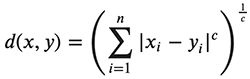

Η ευκλείδια απόσταση σύμφωνα με το σχήμα υπολογίζεται ως εξής. Αφαιρώ το X1 από το X2, τετραγωνίζω το αποτελέσμα, κάνω το ίδιο για τα Y1 και Y2, προσθέτω τα δύο τετράγωνα και στο τέλος τα "βάζω" κάτω από τετραγωνική ρίζα.

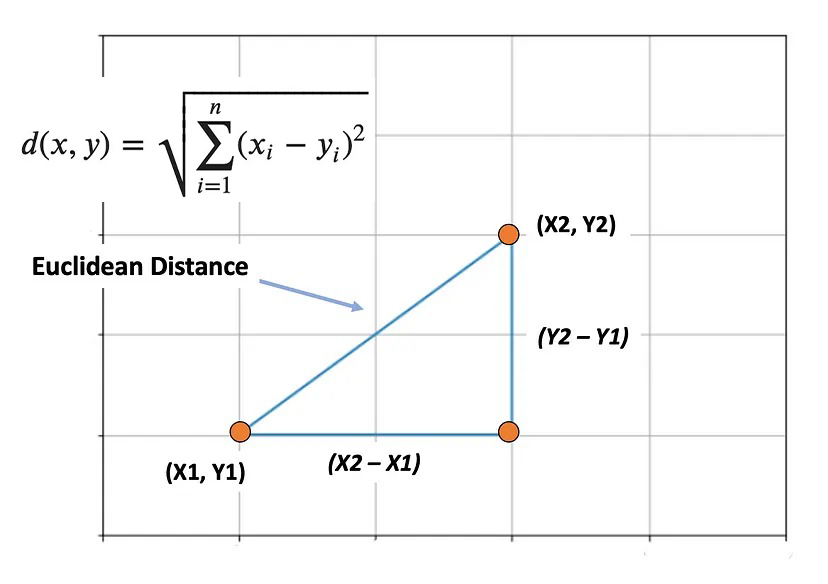

Συνεχίζω τώρα με το κατηγοριοποιητή. Αρχικά χωρίς PCA, έπειτα με PCA.

In [20]:
knn_classifier_1 = train_knn_classifier(x_train_filtered, y_train_filtered, n_neighbors=1, metric='euclidean')

accuracy = test_knn_classifier(knn_classifier_1, x_test_filtered, y_test_filtered)

print(f"For the 1-NN classifier with Euclidean distance metric without PCA the accuracy is: {accuracy:.4f}\n")


knn_classifier_1_pca = train_knn_classifier(x_train_pca, y_train_filtered, n_neighbors=1, metric='euclidean')

accuracy = test_knn_classifier(knn_classifier_1_pca, x_test_pca, y_test_filtered)

print(f"For the 1-NN classifier with Euclidean distance metric with PCA the accuracy is: {accuracy:.4f}")

Training time: 0.0512s

Testing time: 11.0947s

For the 1-NN classifier with Euclidean distance metric without PCA the accuracy is: 0.7455

Training time: 0.0036s

Testing time: 0.9129s

For the 1-NN classifier with Euclidean distance metric with PCA the accuracy is: 0.7510


Πετυχαίνω **0.7455** ακρίβεια χωρίς PCA, ενώ με PCA **0.7510** και μάλιστα σε αρκετά μικρότερο χρόνο. Τώρα θα δοκιμάσω αν αλλάζει κάτι ελέγχοντας τρεις γείτονες.

* **3-NN Model**

In [21]:
knn_classifier_3 = train_knn_classifier(x_train_filtered, y_train_filtered, n_neighbors=3, metric='euclidean')

accuracy = test_knn_classifier(knn_classifier_3, x_test_filtered, y_test_filtered)

print(f"For the 3-NN classifier with Euclidean distance metric without PCA the accuracy is: {accuracy:.4f}\n")

knn_classifier_3_pca = train_knn_classifier(x_train_pca, y_train_filtered, n_neighbors=3, metric='euclidean')

accuracy = test_knn_classifier(knn_classifier_3_pca, x_test_pca, y_test_filtered)

print(f"For the 3-NN classifier with Euclidean distance metric with PCA the accuracy is: {accuracy:.4f}")

Training time: 0.0233s

Testing time: 4.6833s

For the 3-NN classifier with Euclidean distance metric without PCA the accuracy is: 0.7395

Training time: 0.0016s

Testing time: 0.2625s

For the 3-NN classifier with Euclidean distance metric with PCA the accuracy is: 0.7540


Παρατηρώ πως χρειάζεται λιγότερο χρόνο και η ακρίβεια με PCA είναι υψηλότερη από τις προηγούμενες με τιμή **0.7540**.

# Nearest Centroid Models

Ο Nearest Centroid Classifier (NCC) είναι ένα μοντέλο ταξινόμησης που αποδίδει σε παρατηρήσεις την ετικέτα της κατηγορίας δειγμάτων εκπαίδευσης των οποίων ο μέσος όρος (κεντροειδές/centroid) είναι πλησιέστερος στην παρατήρηση.

Μιλώντας με μαθηματικούς όρους, δεδομένου του συνόλου $\left \{ \left ( \vec{x_{1}}, \vec{y_{1}} \right ),..., \left ( \vec{x_{n}}, \vec{y_{n}} \right ) \right \}$, με τα $y_{i}\in \mathbf{Y}$ να είναι οι ετικέτες των κλάσεων, υπολογίζει τους centroids ανά κλάση ως $\vec{\mu _{l}}=\frac{1}{\left | C_{l} \right |}\sum _{i\in C_{l}}\vec{x_{i}}$, όπου $C_{l}$ είναι το σύνολο των δειγμάτων που ανήκουν στην κλάση $l\in \mathbf{Y}$.

Στην φάση της πρόβλεψης η κλάση που αποδίδεται σε μία παρατήρηση $\vec{x}$ είναι το αποτελέσμα του $\hat{y}=\arg \min _{l\in \mathbf{Y}}\left \| \vec{\mu _{l}} - \vec{x} \right \|$.

Όμοια με πριν, θα ορίσω πρώτα τις συναρτήσεις εκπαίδευσης και δοκιμής για καλύτερη ευελιξία.

In [22]:
from sklearn.neighbors import NearestCentroid
import time

In [23]:
def train_nearest_centroid_classifier(x_train, y_train, metric):
    ncc_classifier = NearestCentroid(metric=metric)

    start_time = time.time()
    ncc_classifier.fit(x_train, y_train)
    end_time = time.time()

    training_time = end_time - start_time
    print(f"Training time: {training_time:.4f}s\n")

    return ncc_classifier

In [24]:
def test_nearest_centroid_classifier(ncc_classifier, x_test, y_test):
    start_time = time.time()
    score = ncc_classifier.score(x_test, y_test)
    end_time = time.time()

    testing_time = end_time - start_time
    print(f"Testing time: {testing_time:.4f}s\n")

    return score

* **Ευκλείδια απόσταση**

Τώρα θα τεστάρω τον κατηγοριοποιητή `NearestCentroid`, αρχικά με μετρική την Ευκλείδια απόσταση. Πάλι θα δοκιμάσω αν βοηθάει η εφαρμογή του PCA.

In [25]:
ncc_classifier_euclidean = train_nearest_centroid_classifier(x_train_filtered, y_train_filtered, metric='euclidean')

accuracy = test_nearest_centroid_classifier(ncc_classifier_euclidean, x_test_filtered, y_test_filtered)

print(f"For the Nearest Centroid classifier with Euclidean distance metric without PCA the accuracy is: {accuracy:.4f}\n")

ncc_classifier_euclidean_pca = train_nearest_centroid_classifier(x_train_pca, y_train_filtered, metric='euclidean')

accuracy = test_nearest_centroid_classifier(ncc_classifier_euclidean_pca, x_test_pca, y_test_filtered)

print(f"For the Nearest Centroid classifier with Euclidean distance metric with PCA the accuracy is: {accuracy:.4f}")

Training time: 0.2283s

Testing time: 0.1532s

For the Nearest Centroid classifier with Euclidean distance metric without PCA the accuracy is: 0.6585

Training time: 0.0043s

Testing time: 0.0053s

For the Nearest Centroid classifier with Euclidean distance metric with PCA the accuracy is: 0.6580


Παρατηρώ πως είναι πολύ γρήγορο, αλλά με χειρότερη ακρίβεια και στις δύο περιπτώσεις (**0.6585** και **0.6580**) σε σχέση με τα k-NN. Θα δοκιμάσω να αλλάξω την μετρική στην απόσταση Μανχάταν.

* **Απόσταση Μανχάταν**

Η απόσταση Manhattan διαφέρει από την Ευκλείδια όταν υπολογίζουμε την διαφορά  μεταξύ δύο σημείων χρησιμοποιώντας την απόλυτη τιμή της διαφοράς. Με άλλα λόγια, η απόσταση μεταξύ του σημείου x και του y ισούται με το άθροισμα των απόλυτων διαφορών του Y με το X σε κάθε διάσταση.

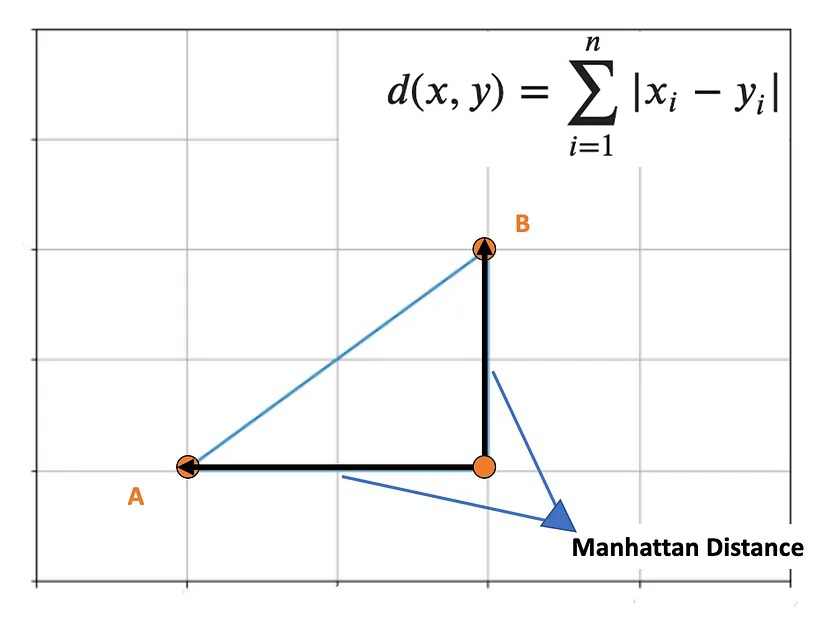

In [26]:
ncc_classifier_manhattan = train_nearest_centroid_classifier(x_train_filtered, y_train_filtered, metric='manhattan')

accuracy = test_nearest_centroid_classifier(ncc_classifier_manhattan, x_test_filtered, y_test_filtered)

print(f"For the Nearest Centroid classifier with Manhattan distance metric without PCA the accuracy is: {accuracy:.4f}\n")

ncc_classifier_manhattan_pca = train_nearest_centroid_classifier(x_train_pca, y_train_filtered, metric='manhattan')

accuracy = test_nearest_centroid_classifier(ncc_classifier_manhattan_pca, x_test_pca, y_test_filtered)

print(f"For the Nearest Centroid classifier with Manhattan distance metric without PCA the accuracy is: {accuracy:.4f}")

Training time: 1.2447s

Testing time: 0.0470s

For the Nearest Centroid classifier with Manhattan distance metric without PCA the accuracy is: 0.6590

Training time: 0.0174s

Testing time: 0.0037s

For the Nearest Centroid classifier with Manhattan distance metric without PCA the accuracy is: 0.6775


Τώρα είναι πιο αργό και ελάχιστα πιο ακριβές (**0.6590** και **0.6775**) από πριν.

# SVM from sklearn

In [33]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import time

* **Linear**:

In [28]:
start_time = time.time()
svm = SVC(kernel='linear')
svm.fit(x_train_pca, y_train_filtered)
training_time = time.time() - start_time

y_train_pred = svm.predict(x_train_pca)
train_accuracy = accuracy_score(y_train_filtered, y_train_pred)

y_test_pred = svm.predict(x_test_pca)
test_accuracy = accuracy_score(y_test_filtered, y_test_pred)

print(f"Training Time: {training_time:.2f} seconds")
print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test_filtered, y_test_pred))

Training Time: 49.16 seconds
Training Accuracy: 71.85%
Test Accuracy: 72.55%

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.70      0.72      1000
           8       0.72      0.75      0.73      1000

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.73      0.73      2000



In [34]:
start_time = time.time()
svm = LinearSVC()
svm.fit(x_train_pca, y_train_filtered)
training_time = time.time() - start_time

y_train_pred = svm.predict(x_train_pca)
train_accuracy = accuracy_score(y_train_filtered, y_train_pred)

y_test_pred = svm.predict(x_test_pca)
test_accuracy = accuracy_score(y_test_filtered, y_test_pred)

print(f"Training Time: {training_time:.2f} seconds")
print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test_filtered, y_test_pred))

Training Time: 6.70 seconds
Training Accuracy: 71.43%
Test Accuracy: 71.65%

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.71      0.71      1000
           8       0.71      0.72      0.72      1000

    accuracy                           0.72      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.72      0.72      0.72      2000



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


* **Polynomial**:

In [29]:
start_time = time.time()
svm = SVC(kernel='poly')
svm.fit(x_train_pca, y_train_filtered)
training_time = time.time() - start_time

y_train_pred = svm.predict(x_train_pca)
train_accuracy = accuracy_score(y_train_filtered, y_train_pred)

y_test_pred = svm.predict(x_test_pca)
test_accuracy = accuracy_score(y_test_filtered, y_test_pred)

print(f"Training Time: {training_time:.2f} seconds")
print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test_filtered, y_test_pred))

Training Time: 10.41 seconds
Training Accuracy: 84.63%
Test Accuracy: 77.70%

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      1000
           8       0.74      0.86      0.79      1000

    accuracy                           0.78      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.78      0.78      0.78      2000



* **Radial Basis Function** (RBF):

In [30]:
start_time = time.time()
svm = SVC(kernel='rbf')
svm.fit(x_train_pca, y_train_filtered)
training_time = time.time() - start_time

y_train_pred = svm.predict(x_train_pca)
train_accuracy = accuracy_score(y_train_filtered, y_train_pred)

y_test_pred = svm.predict(x_test_pca)
test_accuracy = accuracy_score(y_test_filtered, y_test_pred)

print(f"Training Time: {training_time:.2f} seconds")
print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test_filtered, y_test_pred))

Training Time: 10.18 seconds
Training Accuracy: 87.92%
Test Accuracy: 82.00%

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      1000
           8       0.81      0.84      0.82      1000

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



* **Sigmoid**:

In [31]:
start_time = time.time()
svm = SVC(kernel='sigmoid')
svm.fit(x_train_pca, y_train_filtered)
training_time = time.time() - start_time

y_train_pred = svm.predict(x_train_pca)
train_accuracy = accuracy_score(y_train_filtered, y_train_pred)

y_test_pred = svm.predict(x_test_pca)
test_accuracy = accuracy_score(y_test_filtered, y_test_pred)

print(f"Training Time: {training_time:.2f} seconds")
print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test_filtered, y_test_pred))

Training Time: 7.39 seconds
Training Accuracy: 56.06%
Test Accuracy: 55.40%

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.54      0.55      1000
           8       0.55      0.56      0.56      1000

    accuracy                           0.55      2000
   macro avg       0.55      0.55      0.55      2000
weighted avg       0.55      0.55      0.55      2000



# Kernel Functions

The kernel function can be any of the following:

* **Linear**:

$k(x, y) = x\cdot y^T$

επίσης γνωστός ως πυρήνας dot product (εσωτερικού γινομένου).

In [ ]:
def linear_kernel(x1, x2):
    return torch.matmul(x1, x2.t())

* **Polynomial**:

$K(x,y)=(x\cdot y^T +r)^d$

όπου το r είναι ο συντελεστής και d ο βαθμός του πολυωνυμικού πυρήνα.



In [ ]:
def polynomial_kernel(x, y, d, r):
    return (torch.matmul(x, y.t()) + r)**d

* **Radial Basis Function** (RBF):

$K(x, y) = \exp \left( - \frac{||x-y||^2}{2σ^2} \right) = \exp \left( -{γ||x-y||^2}\right)$

όπου το σ προκύπτει από το cross-validation και $\gamma = \frac{1}{2\sigma ^{2}}$.

In [ ]:
def rbf_kernel(x, y, gamma):
    return torch.exp(-gamma * torch.norm(x - y)**2)

* **Sigmoid**:

$K(x, y) = \tanh(cx \cdot y^T + h)$

όπου τα c, h προκύπτουν από το cross-validation.


In [ ]:
def sigmoid_kernel(x, y, c, h):
    return torch.tanh(c * torch.matmul(x, y.t()) + h)

# SVM wit QP

In [ ]:
pip install cvxpy

In [ ]:
import torch
import torch.nn.functional as F
import cvxpy as cp

In [ ]:
import torch
import torch.optim as optim
import time

class SVM(object):

    def __init__(self, kernel, C=None, gamma=None, disp=True):
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        self.disp = disp
        if self.C is not None:
            self.C = float(self.C)

    def fit(self, x_train_filtered, y_train_filtered):
        n_samples, n_features = x_train_filtered.shape

        if self.disp is True:
            print('Number of samples:', n_samples)
            print('Number of features:', n_features)

        # Convert data to PyTorch tensors
        x_train_filtered = torch.tensor(x_train_filtered, dtype=torch.float32)
        y_train_filtered = torch.tensor(y_train_filtered, dtype=torch.float32)

        # Calculate Gram matrix
        start = time.time()
        K = torch.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                if self.kernel is linear_kernel:
                    K[i, j] = self.kernel(x_train_filtered[i], x_train_filtered[j])
                else:
                    K[i, j] = self.kernel(x_train_filtered[i], x_train_filtered[j], self.gamma)
        end = time.time()
        if self.disp is True:
            print("Gram matrix elapsed time: {}s\n".format(end - start))

        # Formulate the matrices of the QP problem
        P = torch.outer(y_train_filtered, y_train_filtered) * K
        q = torch.ones(n_samples) * -1.0
        A = y_train_filtered.view(1, -1).double()
        b = torch.tensor([0.0], dtype=torch.double)

        if self.C is None:
            G = torch.diag(torch.ones(n_samples) * -1)
            h = torch.zeros(n_samples)
        else:
            G_1 = -1 * torch.eye(n_samples)
            G_2 = torch.eye(n_samples)
            G = torch.cat((G_1, G_2), dim=0)
            h_1 = torch.zeros(n_samples)
            h_2 = torch.ones(n_samples) * self.C
            h = torch.cat((h_1, h_2))

        # Solve QP problem
        start = time.time()
        solution = self.solve_qp(P, q, G, h, A, b)
        end = time.time()

        if self.disp is True:
            print("QP solver elapsed time: {}s\n".format(end - start))

        # Lagrange multipliers
        a = solution.ravel()

        # Find Support Vectors
        sv = a > 1e-3
        self.a = a[sv]
        self.sv = x_train_filtered[sv]
        self.sv_y = y_train_filtered[sv]
        ind = torch.arange(len(a))[sv]  # just a trick to get the indexes which are also stored in sv

        # Bias (calculated for each sv and then we take the mean for numerical stability reasons)
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= torch.sum(self.a * self.sv_y * K[ind[n], sv])
        self.b /= len(self.a)

    def predict(self, x_test_filtered):
        start = time.time()
        y_pred = torch.zeros(len(x_test_filtered))
        for i in range(len(x_test_filtered)):
            for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                if self.kernel is linear_kernel:
                    y_pred[i] += a * sv_y * self.kernel(x_test_filtered[i], sv)
                else:
                    y_pred[i] += a * sv_y * self.kernel(x_test_filtered[i], sv, self.gamma)
        y_pred += self.b
        end = time.time()
        if self.disp is True:
            print("Testing elapsed time: {}s\n".format(end - start))
        return torch.sign(y_pred).int()


    def solve_qp(self, P, q, G, h, A, b):
        # Convert PyTorch tensors to NumPy arrays and cast to double precision
        P, G, A = map(lambda x: x.numpy().astype(np.double), [P, G, A])

        # Convert q, h, and b to one-dimensional NumPy arrays
        q, h, b = q.numpy().ravel().astype(np.double), h.numpy().ravel().astype(np.double), b.numpy().ravel().astype(np.double)

        # Ensure 1D arrays have a shape of (n,) instead of (n, 1)
        q, h, b = q.squeeze(), h.squeeze(), b.squeeze()

        # Solve QP problem
        P = np.ascontiguousarray(P)  # Ensure contiguous memory layout
        G, A = np.ascontiguousarray(G), np.ascontiguousarray(A)  # Ensure contiguous memory layout
        solution, _, _, _, _ = solve_qp(P, q, G.T, h, A.T, b)

        # Convert the solution back to a PyTorch tensor
        solution = torch.tensor(solution, dtype=torch.float32)

        return solution

In [ ]:
pip install quadprog

In [ ]:
import torch
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from quadprog import solve_qp
# Assume x_train_pca, y_train, x_test_pca, y_test are PyTorch tensors

# The training subset consists of 2000 samples
rand_indx = torch.randint(0, len(x_train_pca), (10000,))
x_train_mini = x_train_pca[rand_indx, :]
y_train_mini = y_train_filtered[rand_indx]

# Train the model
svm = SVM(kernel=linear_kernel, C=1, gamma=None, disp=True)
svm.fit(x_train_mini, y_train_mini)

# Evaluate on test set
y_pred = svm.predict(x_test_pca)

# Convert y_test and y_pred to numpy arrays for sklearn metrics
y_test_np = y_test_filtered.numpy()
y_pred_np = y_pred.numpy()

print('Test set accuracy: ', accuracy_score(y_test_np, y_pred_np))
print(classification_report(y_test_np, y_pred_np))

Number of samples: 10000
Number of features: 76
Gram matrix elapsed time: 1987.0710225105286s



TypeError: ignored